In [1]:
from __future__ import print_function
import tables as tb
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import copy

import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm
import Core.sensorFunctions as sns
import Core.fitFunctions as fit
import Core.tblFunctions as tbl

import Database.loadDB as DB

matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8) # Bigger plots
%matplotlib inline
%load_ext autoreload
%autoreload 2

print("This notebook has been run last on {} at {}.".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

This notebook has been run last on 28/11/2016 at 15:01:43.


In [2]:
try:
    h5f.close()
except:
    pass

In [3]:
pmaps = []
for ifile in range(1):
    print("File", ifile)
    with tb.open_file('/Users/Gonzalo/github/IC/data/DATA/run_2948_{}_DST.h5'.format(ifile)) as h5f:
        pmaptbl = h5f.root.PMAPS.PMaps
        pmaps_ = [tbl.read_pmap(pmaptbl, ievt) for ievt in range(tbl.get_nofevents(pmaptbl, "event"))]
        pmaps.extend(pmaps_)

File 0


In [4]:
h5data = tb.open_file('/Users/Gonzalo/github/IC/data/DATA/run_2948_0_RWF.h5')

In [5]:
adc_to_pes = abs(1.0/DB.DataPMT()["adc_to_pes"].reshape(12, 1))
sipmdf = DB.DataSiPM()

In [6]:
def sum_zs(wf):
    return np.sum(wf[wf>1.])

In [16]:
pmaps[6].peaks[0]

Peak type: S1 Cathode sum: 0.935595393181 Anode sum: 0.0
time ToT cathode anode
33.0 3 0.935595393181 []

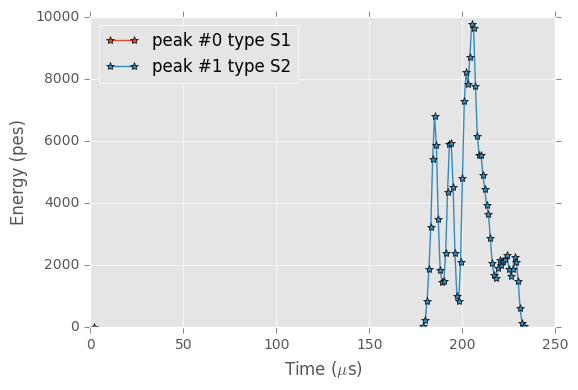

In [31]:
mpl.plot_pmap(pmaps[7])

(99, 102)

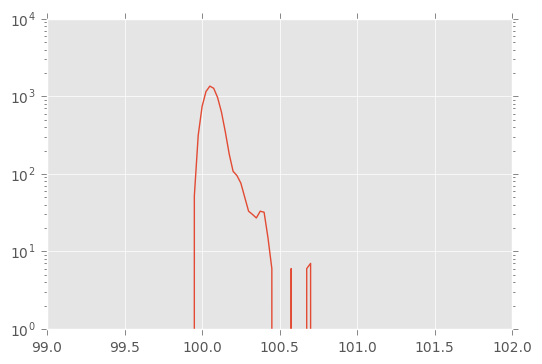

In [39]:
plt.plot(np.arange(32000)/40., h5data.root.ZS.PMT[7].sum(axis=0))
plt.yscale("log")
plt.xlim((99,102))

In [26]:
from Core.Bridges import *
import Core.system_of_units as units
import math

In [27]:
def build_pmap(pmtwf, sipmwfs, stride=40):
    """
    Finds any peak in the waveform and rebins it.
    """
    to_mus = 25*stride*units.ns/units.mus

    nbins = int(math.ceil(len(pmtwf)*1.0/stride))
    pmap = PMap()
    ene_pmt = []
    ene_sipms = []
    time_over_thrs = []
    tmin = float("inf")

    for i in range(nbins):
        low = i * stride
        upp = low + stride
        slice_ = pmtwf[low:upp]
        e = slice_.sum()
        q = sipmwfs[:, i].flatten()
        t = i

        # Non-empty slice, append it and carry on
        if e > 0.:
            if t < tmin:
                tmin = t
            ene_pmt.append(e)
            # q = np.concatenate((q,np.zeros(3)))
            ene_sipms.append(q)
            time_over_thrs.append(np.nonzero(slice_)[0].size)

        # Empty slice. Everything accumulated so far is a peak.
        # It will be S1-like if it is a short peak
        elif len(ene_pmt) > 0:
            tmax = t
            peak = Peak(np.arange(tmin, tmax)*to_mus,
                        ene_pmt, ene_sipms, time_over_thrs)
            pmap.peaks.append(peak)

            tmin = float("inf")
            ene_pmt = []
            ene_sipms = []
            time_over_thrs = []

    return pmap

In [33]:
build_pmap(h5data.root.ZS.PMT[7].sum(axis=0), h5data.root.ZS.SiPM[7])

PMAP with 79 peaks. Event t0 = -1.0 mus

Peak #0
Peak type: ?? Cathode sum: 15 Anode sum: 0
time ToT cathode anode
2.0 2 15 []
Peak #1
Peak type: ?? Cathode sum: 21 Anode sum: 0
time ToT cathode anode
33.0 3 21 []
Peak #2
Peak type: ?? Cathode sum: 13 Anode sum: 0
time ToT cathode anode
59.0 2 13 []
Peak #3
Peak type: ?? Cathode sum: 37 Anode sum: 0
time ToT cathode anode
80.0 4 37 []
Peak #4
Peak type: ?? Cathode sum: 7535 Anode sum: 0
time ToT cathode anode
99.0 2 367 []
100.0 22 7168 []
Peak #5
Peak type: ?? Cathode sum: 6 Anode sum: 0
time ToT cathode anode
102.0 1 6 []
Peak #6
Peak type: ?? Cathode sum: 24 Anode sum: 0
time ToT cathode anode
119.0 3 24 []
Peak #7
Peak type: ?? Cathode sum: 4683312 Anode sum: 161733
time ToT cathode anode
179.0 34 788 [(1070, 108)]
180.0 40 5626 [(1058, 127), (1070, 186)]
181.0 40 20358 [(1058, 228), (1059, 69), (1067, 126), (1069, 153), (1070, 461), (1071, 236)]
182.0 40 45155 [(1057, 162), (1058, 405), (1059, 97), (1060, 116), (1063, 164), (1064,

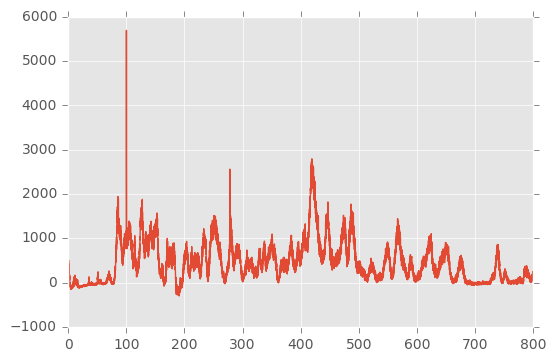

In [59]:
plt.plot(np.arange(32000.)/40., h5data.root.RD.pmtcwf[:100,0,:].sum(axis=0))

In [ ]:
h = plt.hist([sum_zs(wf*adc_to_pes) for wf in h5data.root.RD.pmtcwf], 200, range=(0,4e5))
plt.yscale("log")

In [5]:
def baricenter(peak, sipmdf, thrs=0.25):
    q = np.nansum(peak.anode, axis=0)
    selection = q > np.max(q) * thrs
    q = q[selection]
    if not q.sum():
        return 0., 0.
    x = np.average(sipmdf["X"].values[selection], weights=q)
    y = np.average(sipmdf["Y"].values[selection], weights=q)
    return x, y


def get_xye(peak, sipmdf, thrs=0.2, att_corr=1.):
    x, y = baricenter(peak, sipmdf, thrs)
    return x, y, peak.cathode_integral * att_corr

In [63]:
def XRselector(pmap):
    s1s = pmap.get("S1")
    if not len(s1s) or not any(abs(s1.peakmax[0]-100.)<2. for s1 in s1s):
        return False
    s2s = pmap.get("S2")
    if len(s2s) <= 1:
        return False
    return True
#    return 0 < s2s[0].cathode_integral < 125000

def isXR(peak):
    return 3500 < peak.cathode_integral < 6500

In [68]:
XR = filter(XRselector, pmaps)
print("{:.2f}% = {} pmaps".format(len(XR)*100./len(pmaps), len(XR)))

5.47% = 722 pmaps


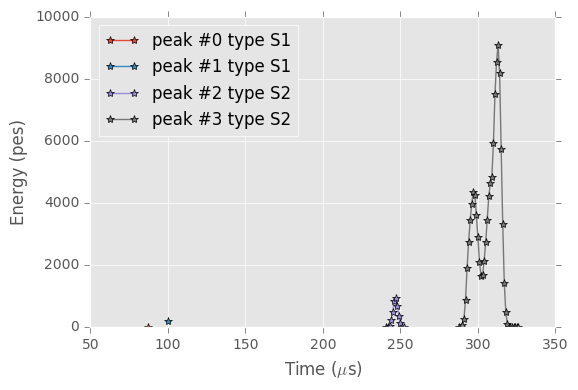

In [66]:
mpl.plot_pmap(XR[1])

In [8]:
def plot_anode(data, full_evt=True, show_baricenter=True):
    if full_evt:
        sipms_integral = np.nansum(np.concatenate([peak.anode for peak in data], axis=0), axis=0)
    else:
        sipms_integral = np.nansum(data.anode, axis=0)
    fig = plt.figure()
    xmin, xmax = np.nanmin(sipmdf["X"].values), np.nanmax(sipmdf["X"].values)
    ymin, ymax = np.nanmin(sipmdf["Y"].values), np.nanmax(sipmdf["Y"].values)
    selection = sipms_integral > np.nanmax(sipms_integral) * 0.1
    x, y, z = sipmdf["X"][selection], sipmdf["Y"][selection], sipms_integral[selection]
    scplot = plt.scatter(x, y, c=z)
    if show_baricenter and not full_evt:
        xb, yb = baricenter(data, sipmdf)
        plt.plot([xb], [yb], "r*")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))
    plt.tight_layout()
    fig.colorbar(scplot, ax=plt.gca()).set_label("Charge (pes)")


def plot_slice(slice_):
    sipms_integral = slice_
    fig = plt.figure()
    xmin, xmax = np.nanmin(sipmdf["X"].values), np.nanmax(sipmdf["X"].values)
    ymin, ymax = np.nanmin(sipmdf["Y"].values), np.nanmax(sipmdf["Y"].values)
    selection = sipms_integral > np.nanmax(sipms_integral) * 0.1
    x, y, z = sipmdf["X"][selection], sipmdf["Y"][selection], sipms_integral[selection]
    scplot = plt.scatter(x, y, c=z)
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))
    plt.tight_layout()
    fig.colorbar(scplot, ax=plt.gca()).set_label("Charge (pes)")


def plot_q_order(peak):
    qs = np.fliplr(np.sort(np.nansum(peak.anode, axis=0)))
    plt.plot(qs)

    
from matplotlib import animation, rc
from IPython.display import HTML


def make_movie(pmap):
    rc('animation', html='html5')
#    matplotlib.rcParams['animation.writer'] = 'avconv'
    fig, ax = plt.subplots()
    xmin, xmax = np.nanmin(sipmdf["X"].values), np.nanmax(sipmdf["X"].values)
    ymin, ymax = np.nanmin(sipmdf["Y"].values), np.nanmax(sipmdf["Y"].values)
    ax.set_xlabel("x (mm)")
    ax.set_ylabel("y (mm)")
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    scplot = ax.scatter([], [], c=[])
    slices = [slice_ for peak in pmap for slice_ in peak.anode]
    cbar = fig.colorbar(scplot, ax=ax, vmin=0, vmax=np.max(slices))
    cbar.set_label("Charge (pes)")
    def init():
#        scplot.set_data([], [], c=[])
        return (scplot,)
    def animate(i):
        sipms_integral = slices[i]
        selection = sipms_integral > np.nanmax(sipms_integral) * 0.1
        x, y = sipmdf["X"][selection].values, sipmdf["Y"][selection].values
        z = sipms_integral[selection]
        scplot.set_offsets([x, y])
        scplot.set_array(z)
        cbar.update_bruteforce(scplot)
        return (scplot,)
    
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(slices), interval=200, blit=False)
#    HTML(anim.to_html5_video())
    return anim
    

def make_movie(pmap):
    rc('animation', html='html5')
#    matplotlib.rcParams['animation.writer'] = 'avconv'
    fig, ax = plt.subplots()
    cbar = 0
    slices = [slice_ for peak in pmap for slice_ in peak.anode]
    def init():
        global cbar, scplot
        xmin, xmax = np.nanmin(sipmdf["X"].values), np.nanmax(sipmdf["X"].values)
        ymin, ymax = np.nanmin(sipmdf["Y"].values), np.nanmax(sipmdf["Y"].values)
        ax.set_xlabel("x (mm)")
        ax.set_ylabel("y (mm)")
        ax.set_xlim((xmin, xmax))
        ax.set_ylim((ymin, ymax))
        scplot = ax.scatter([], [], c=[])
        slices = [slice_ for peak in pmap for slice_ in peak.anode]
        cbar = fig.colorbar(scplot, ax=ax)
        cbar.set_label("Charge (pes)")
        return (scplot,)
    def animate(i):
        global cbar, scplot
        sipms_integral = slices[i]
        selection = sipms_integral > np.nanmax(sipms_integral) * 0.1
        x, y = sipmdf["X"][selection].values, sipmdf["Y"][selection].values
        z = sipms_integral[selection]
        xmin, xmax = np.nanmin(sipmdf["X"].values), np.nanmax(sipmdf["X"].values)
        ymin, ymax = np.nanmin(sipmdf["Y"].values), np.nanmax(sipmdf["Y"].values)
        cbar.remove()
        fig.clear()
#        scplot.set_offsets([x,y])
#        scplot.set_array(z)
        ax = plt.gca()
        ax.set_xlabel("x (mm)")
        ax.set_ylabel("y (mm)")
        ax.set_xlim((xmin, xmax))
        ax.set_ylim((ymin, ymax))
        scplot = ax.scatter(x, y, c=z)
        cbar = fig.colorbar(scplot, ax=ax)
        cbar.set_label("Charge (pes)")
        return (scplot,)
    
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(slices), interval=200, blit=False)
#    HTML(anim.to_html5_video())
    return anim
    


# Energy spectrum (full & XR w/o fiducialization)

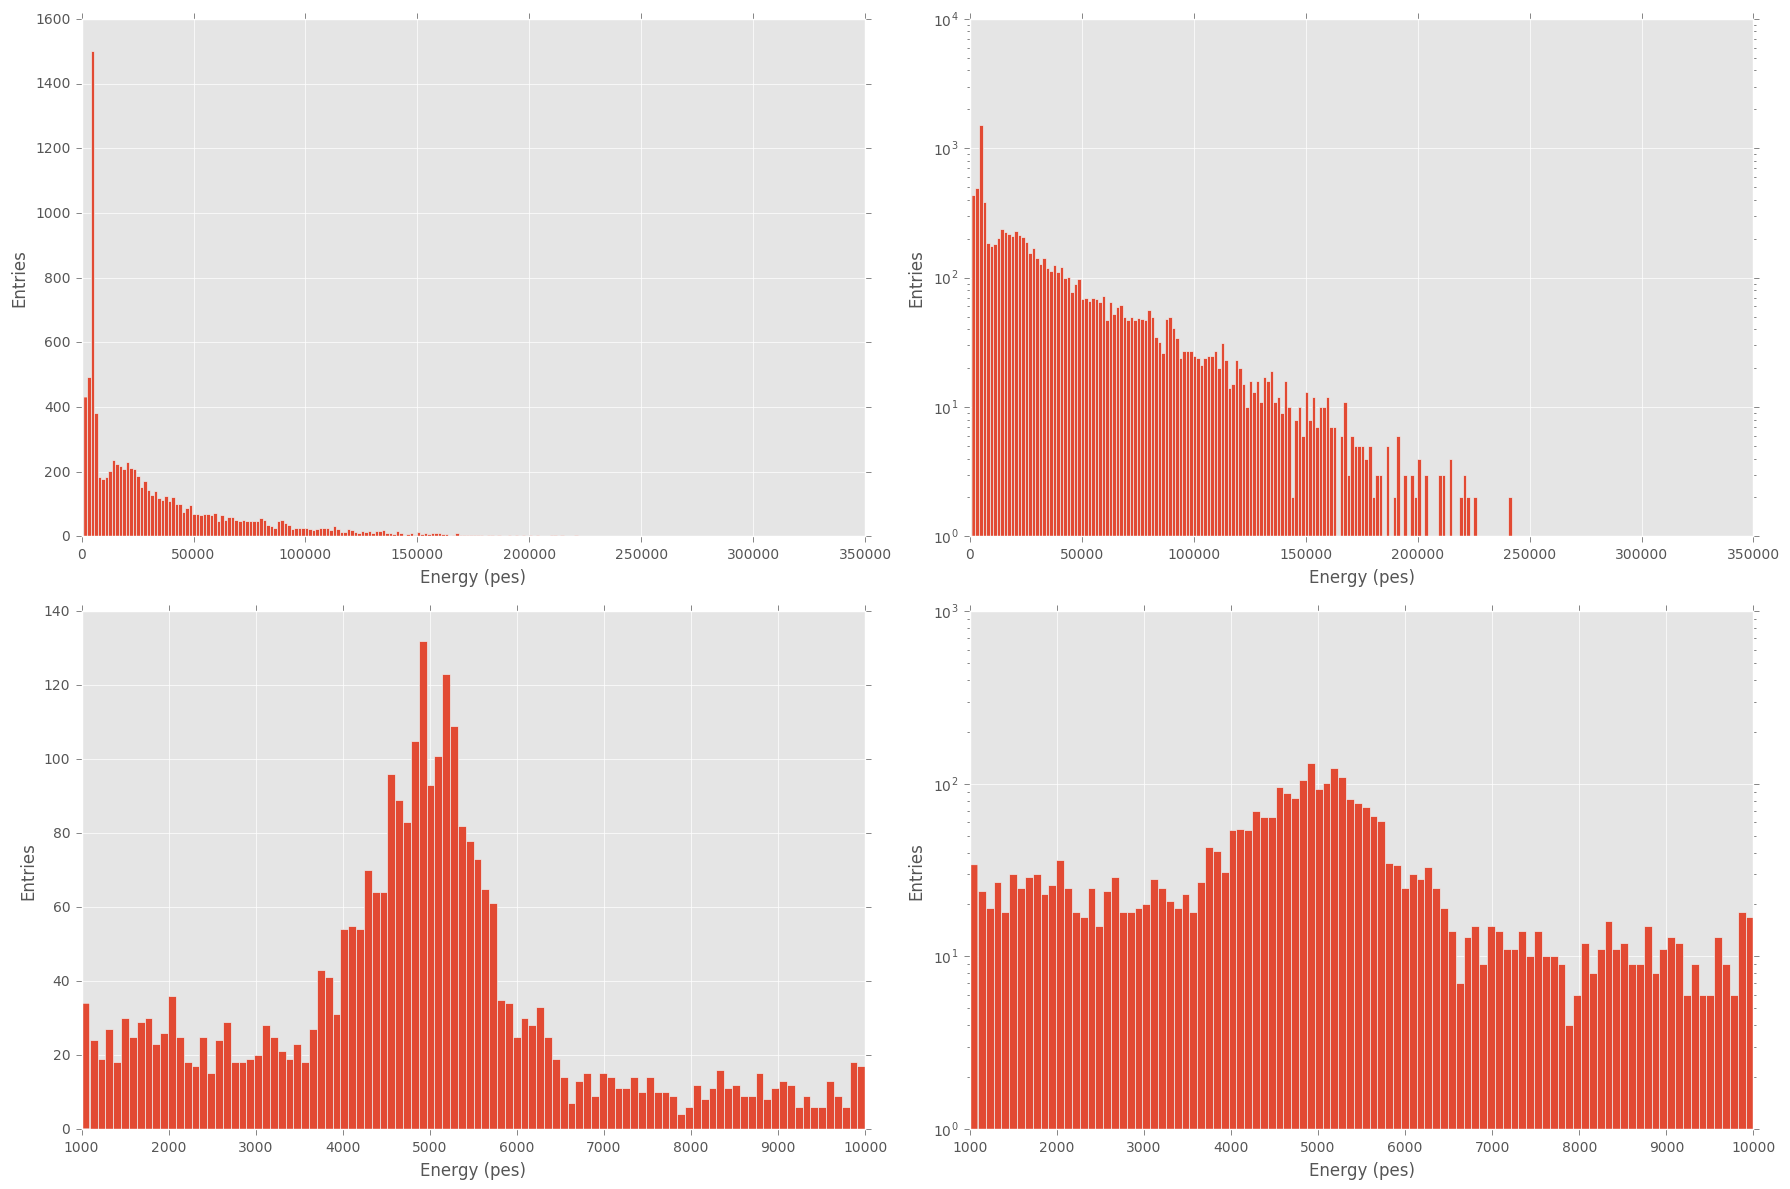

In [10]:
fig, axes = plt.subplots(2,2)
fig.set_size_inches(18,12)
E = np.array([peak.cathode_integral for pmap in XR for peak in pmap])
E = E[E>500]
h = axes[0,0].hist(E, 200)
h = axes[0,1].hist(E, 200)

E = E[E<1e4]
h = axes[1,0].hist(E, 100)
h = axes[1,1].hist(E, 100)

for ax in axes.flatten():
    ax.set_xlabel("Energy (pes)")
    ax.set_ylabel("Entries")

axes[0,1].set_yscale("log")
axes[1,1].set_yscale("log")
plt.tight_layout()

# Energy spectrum (full & XR with 10 cm fiducialization)

In [11]:
def in_fiducial(peak, sipmdf, rmax=100.):
    x, y = baricenter(peak, sipmdf)
    return x**2 + x**2 < rmax**2

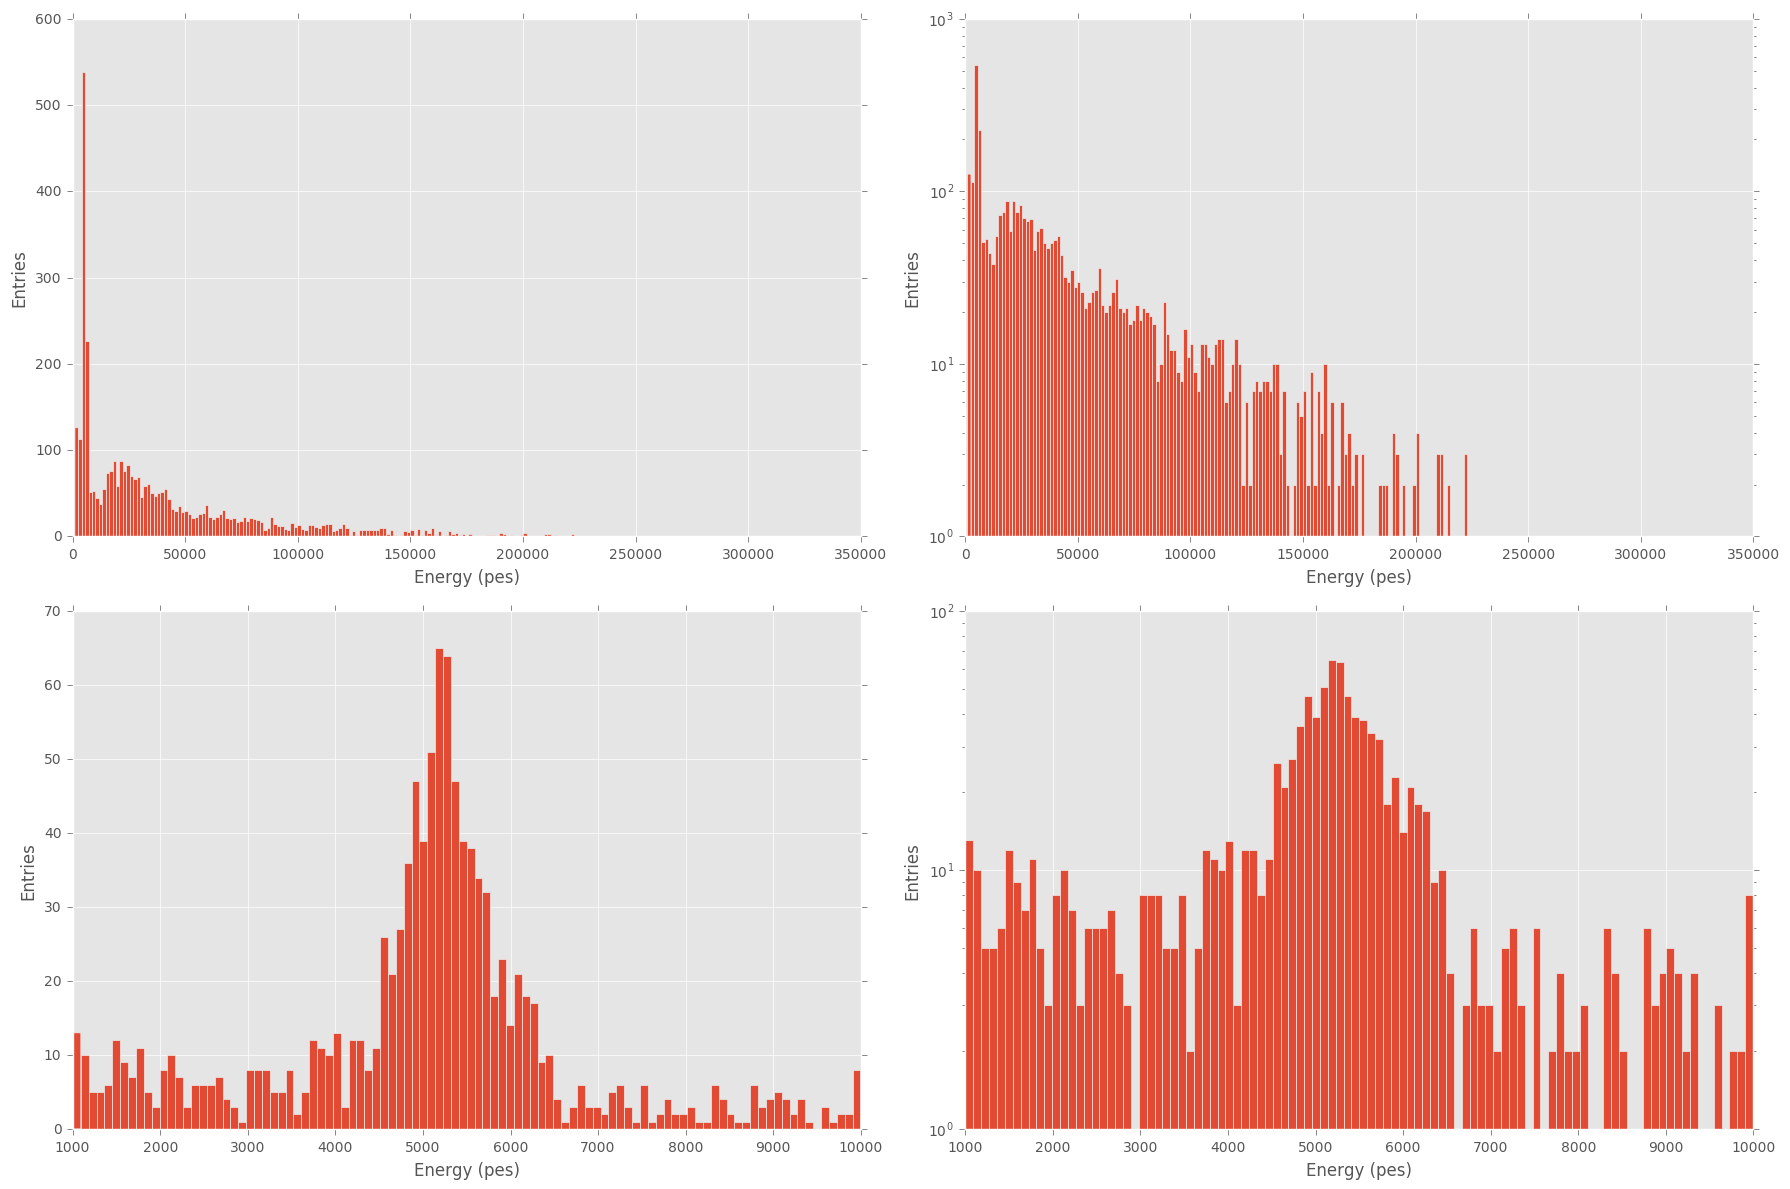

In [12]:
fig, axes = plt.subplots(2,2)
fig.set_size_inches(18,12)
E = np.array([peak.cathode_integral for pmap in XR for peak in pmap if in_fiducial(peak, sipmdf)])
E = E[E>500]
h = axes[0,0].hist(E, 200)
h = axes[0,1].hist(E, 200)

E = E[E<1e4]
h = axes[1,0].hist(E, 100)
h = axes[1,1].hist(E, 100)

for ax in axes.flatten():
    ax.set_xlabel("Energy (pes)")
    ax.set_ylabel("Entries")

axes[0,1].set_yscale("log")
axes[1,1].set_yscale("log")
plt.tight_layout()

# Fit to XR peak (w/o fidufialization)

1.3e+05 +- 5e+03
5e+03 +- 20
5.7e+02 +- 22
1.7e+03 +- 1.8e+03
6.3e+03 +- 1.1e+02
1e+02 +- 1.1e+02
33 +- 2.7
-7.2e+03 +- 1e+03
Resolution = 26.8950598674 @ 30 keV
Resolution = 2.9712705842 @ Qbb


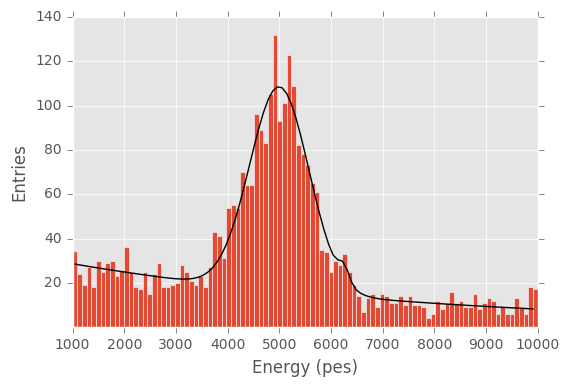

In [13]:
E = np.array([peak.cathode_integral for pmap in XR for peak in pmap])
E = E[(E>500) & (E<1e4)]

h = plt.hist(E, 100)

x = h[1][:-1]
y = h[0]
#g, v, e = fit.fit("gauss + expo", x, y, (2e5, 4900., 400., 50., -2e+4))
g, v, e = fit.fit("gauss + gauss + expo", x, y, (2e5, 5200., 400., 1e2, 6300., 500., 10., -1e4),
                  bounds=[(1e4, 5000., 200., 1e1, 6000, 100.,1e-1,-2e4),
                          (3e6, 5500., 600., 5e4, 6800, 800., 50., -5e3)])

plt.plot(x, g(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
print("\n".join(["{:.2g} +- {:.2g}".format(vi, ei) for vi, ei in zip(v, e)]))
print("Resolution = {} @ 30 keV".format(235.*v[2]/v[1]))
print("Resolution = {} @ Qbb".format(235.*v[2]/v[1]*(30./2458.)**0.5))

plt.ylim((1e-1, plt.ylim()[1]))
pass

# Fit to XR peak (with 10 cm fidufialization)

5.02e+04 +- 1.9e+03
5.17e+03 +- 15
395 +- 17
4.9e+03 +- 1.2e+03
6.12e+03 +- 41
164 +- 42
9.62 +- 1.3
-7.41e+03 +- 1.7e+03
Resolution = 17.9785085093 @ 30 keV
Resolution = 1.98620169447 @ Qbb


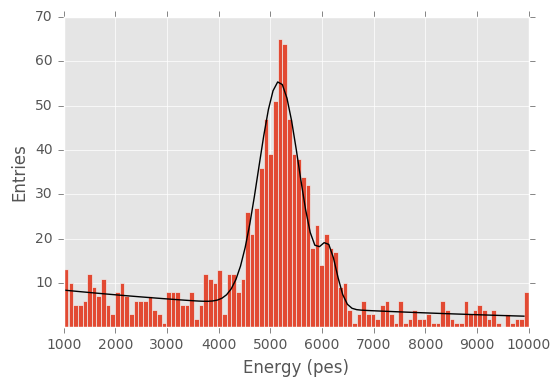

In [14]:
E = np.array([peak.cathode_integral for pmap in XR for peak in pmap if in_fiducial(peak, sipmdf)])
E = E[(E>500) & (E<1e4)]

h = plt.hist(E, 100)

x = h[1][:-1]
y = h[0]
#g, v, e = fit.fit("gauss + expo", x, y, (2e5, 4900., 400., 50., -2e+4))
g, v, e = fit.fit("gauss + gauss + expo", x, y, (2e5, 5200., 400., 1e2, 6300., 500., 10., -1e4),
                  bounds=[(1e4, 5000., 200., 1e1, 6000, 100.,1e-1,-2e4),
                          (3e6, 5500., 600., 5e4, 6800, 800., 50., -5e3)])

plt.plot(x, g(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
print("\n".join(["{:.3g} +- {:.2g}".format(vi, ei) for vi, ei in zip(v, e)]))
print("Resolution = {} @ 30 keV".format(235.*v[2]/v[1]))
print("Resolution = {} @ Qbb".format(235.*v[2]/v[1]*(30./2458.)**0.5))

plt.ylim((1e-1, plt.ylim()[1]))
pass

# Correction by attachment

5.04e+03 · exp(x/-1.96e+04)


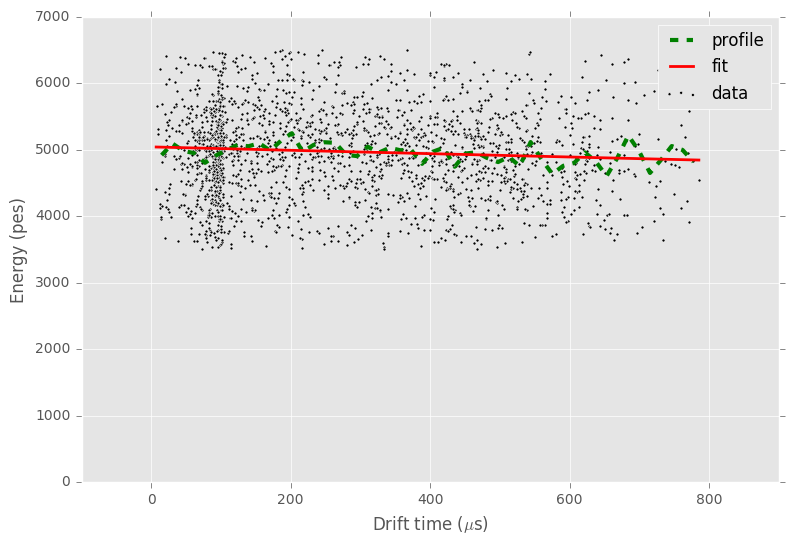

In [62]:
z = []
E = []
for pmap in XR:
    pmap.t0 = pmap.get("S1")[0].peakmax[0]
    for peak in pmap:
        peak.z = peak.peakmax[0] - pmap.t0
        if not isXR(peak):
            continue
        z.append(peak.z)
        E.append(peak.cathode_integral)

zp, Ep, Ep_err = mpl.profile(z, E, 50)
p = plt.scatter(z, E, marker=".", facecolors="k", label="data")
p = plt.plot(zp, Ep, "g--", linewidth=3, label="profile")

plt.ylim((0,7000))
f, v, e = fit.fit("expo", zp, Ep, (6000., -1e4))
print("{:.3g} · exp(x/{:.3g})".format(*v))
x = np.linspace(np.min(z), np.max(z), 100)
y = f(x)
plt.plot(x, y, "r-", linewidth=2, label="fit")
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("Energy (pes)")
plt.legend()
plt.gcf().set_size_inches(9,6)

att_func = copy.copy(f)

In [16]:
att_corr = lambda x: att_func(0.)/att_func(x)

5.05e+04 +- 1.9e+03
5.24e+03 +- 16
403 +- 18
5.13e+03 +- 1.4e+03
6.2e+03 +- 49
190 +- 49
9.52 +- 1.2
-7.17e+03 +- 1.6e+03
Resolution = 18.0776268196 @ 30 keV
Resolution = 1.99715193295 @ Qbb


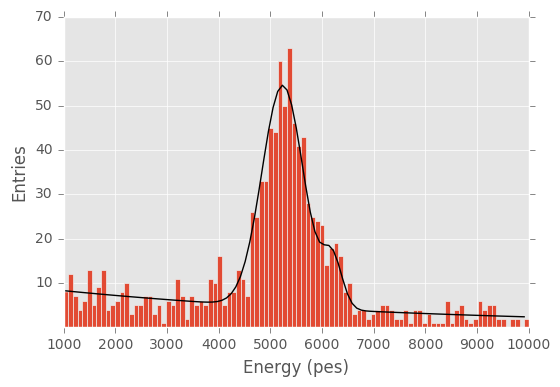

In [17]:
E = np.array([peak.cathode_integral * att_corr(peak.z) for pmap in XR for peak in pmap if in_fiducial(peak, sipmdf)])
E = E[(E>500) & (E<1e4)]

h = plt.hist(E, 100, range=(1e3, 1e4))

x = h[1][:-1]
y = h[0]
#g, v, e = fit.fit("gauss + expo", x, y, (2e5, 4900., 400., 50., -2e+4))
g, v, e = fit.fit("gauss + gauss + expo", x, y, (2e5, 5200., 400., 1e2, 6300., 500., 10., -1e4),
                  bounds=[(1e4, 5000., 200., 1e1, 6000, 100.,1e-1,-2e4),
                          (3e6, 5500., 600., 5e4, 6800, 800., 50., -5e3)])

plt.plot(x, g(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
print("\n".join(["{:.3g} +- {:.2g}".format(vi, ei) for vi, ei in zip(v, e)]))
print("Resolution = {} @ 30 keV".format(235.*v[2]/v[1]))
print("Resolution = {} @ Qbb".format(235.*v[2]/v[1]*(30./2458.)**0.5))

plt.ylim((1e-1, plt.ylim()[1]))
pass

# Geometrical corrections

5.5e+03 + -1.86x + -0.014x^2


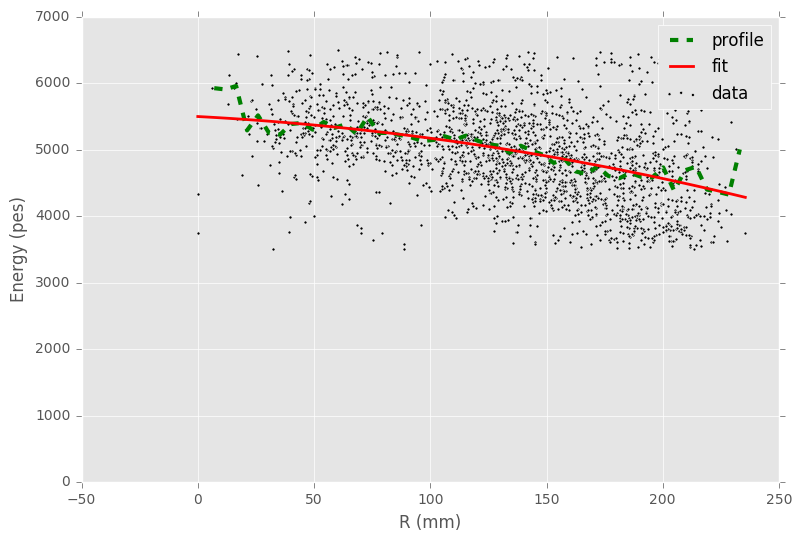

In [23]:
r = []
E = []
for pmap in XR:
    for peak in pmap:
        peak.x, peak.y = baricenter(peak, sipmdf)
        peak.r = (peak.x**2 + peak.y**2)**0.5
        if not isXR(peak):
            continue
        r.append(peak.r)
        E.append(peak.cathode_integral)

rp, Ep, Ep_err = mpl.profile(r, E, 50)
p = plt.scatter(r, E, marker=".", facecolors="k", label="data")
p = plt.plot(rp, Ep, "g--", linewidth=3, label="profile")

f, v, e = fit.fit("polynom", r, E, (6000., -1e-2, -1e-4))
print("{:.3g} + {:.3g}x + {:.3g}x^2".format(*v))
x = np.linspace(np.min(r), np.max(r), 100)
y = f(x)
plt.plot(x, y, "r-", linewidth=2, label="fit")
plt.ylim((0,7000))
plt.xlabel("R (mm)")
plt.ylabel("Energy (pes)")
plt.legend()
plt.gcf().set_size_inches(9,6)

geo_func = copy.copy(f)

In [24]:
geo_corr = lambda x: geo_func(0.)/geo_func(x)

5.45e+04 +- 1.7e+03
5.55e+03 +- 13
440 +- 15
3.66e+03 +- 9e+02
6.61e+03 +- 34
137 +- 35
7.35 +- 1
-9.28e+03 +- 2.6e+03
Resolution = 18.6309595083 @ 30 keV
Resolution = 2.05828216093 @ Qbb


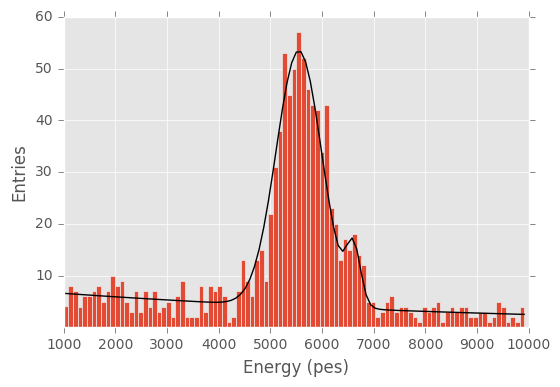

In [33]:
E = np.array([peak.cathode_integral * att_corr(peak.z) * geo_corr(peak.r) for pmap in XR for peak in pmap if in_fiducial(peak, sipmdf)])
E = E[(E>500) & (E<1e4)]

h = plt.hist(E, 100, range=(1e3, 1e4))

x = h[1][:-1]
y = h[0]
#g, v, e = fit.fit("gauss + expo", x, y, (2e5, 4900., 400., 50., -2e+4))
g, v, e = fit.fit("gauss + gauss + expo", x, y, (2e5, 5800., 350., 1e2, 6800., 500., 10., -1e4),
                  bounds=[(1e4, 5200., 200., 1e1, 6300, 100., 1.0,-2e4),
                          (3e6, 6000., 440., 5e4, 7000, 800., 50., -5e3)])

plt.plot(x, g(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
print("\n".join(["{:.3g} +- {:.2g}".format(vi, ei) for vi, ei in zip(v, e)]))
print("Resolution = {} @ 30 keV".format(235.*v[2]/v[1]))
print("Resolution = {} @ Qbb".format(235.*v[2]/v[1]*(30./2458.)**0.5))

plt.ylim((1e-1, plt.ylim()[1]))
pass

# Event distribution

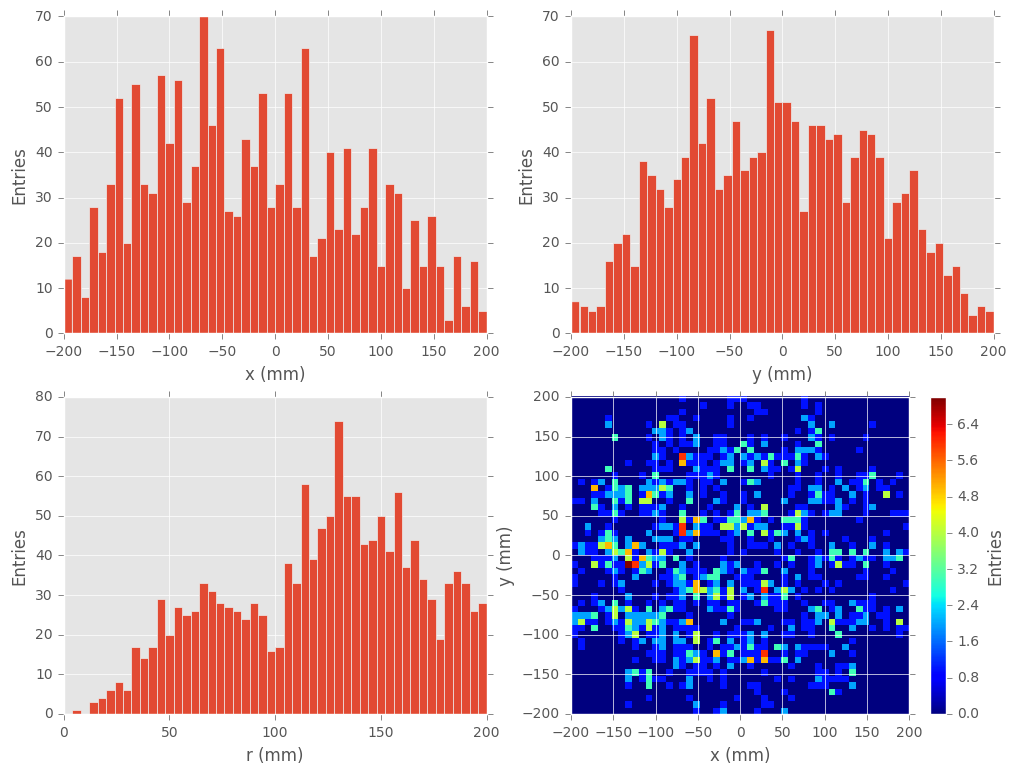

In [39]:
x, y, r, E = map(np.array, zip(*[(peak.x, peak.y, peak.r, peak.cathode_integral*att_corr(peak.z)*geo_corr(peak.r)) for pmap in XR for peak in pmap]))
selection = (E>5000) & (E<7000)
x, y, r, E = x[selection], y[selection], r[selection], E[selection]

plt.subplot(2,2,1)
h = plt.hist(x, 50, range=(-200., 200.))
plt.xlabel("x (mm)")
plt.ylabel("Entries")

plt.subplot(2,2,2)
h = plt.hist(y, 50, range=(-200., 200.))
plt.xlabel("y (mm)")
plt.ylabel("Entries")

plt.subplot(2,2,3)
h = plt.hist(r, 50, range=(0., 200.))
plt.xlabel("r (mm)")
plt.ylabel("Entries")

plt.subplot(2,2,4)
h = plt.hist2d(x, y, 50, range=((-200., 200.), (-200., 200.)))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar().set_label("Entries")

plt.gcf().set_size_inches(12, 9)

In [ ]:
plt.scatter()

In [71]:
pmap = tbl.read_pmap(pmaps_, 0)

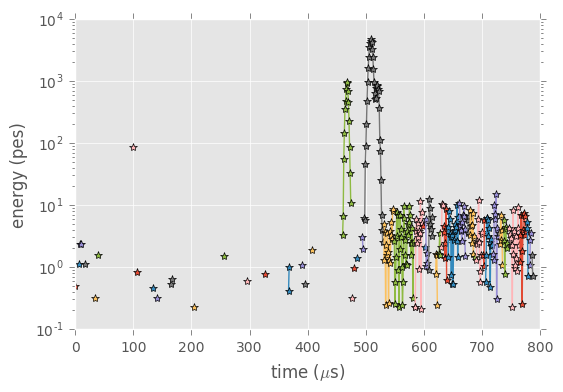

In [72]:
mpl.plot_pmap(pmap)
plt.yscale("log")

##### Reco functions

# XY event distribution

In [149]:
data = [get_xye(peak, sipmdf) for pmap in XR for peak in pmap if isXR(peak)]
#data = filter(lambda x: x[0] != 200. and x[1] != 200., data)
x, y, E = map(np.array, zip(*data))

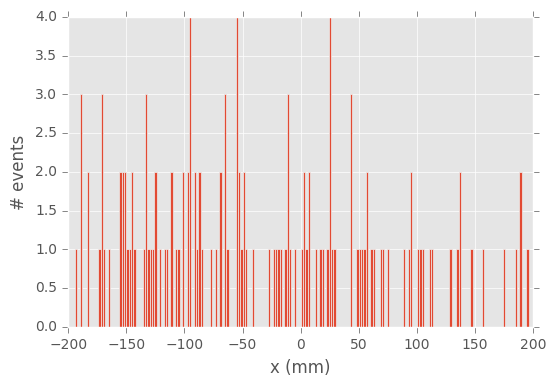

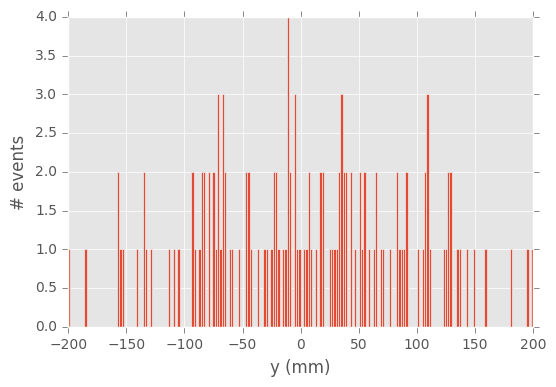

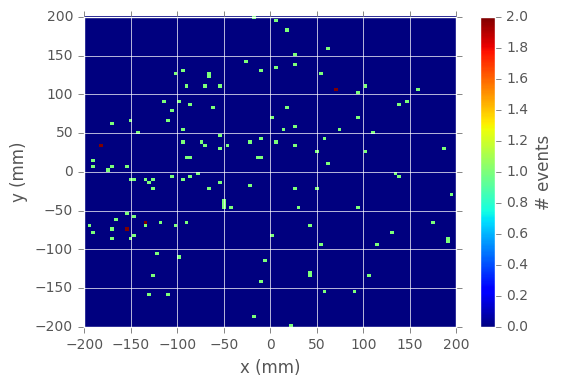

In [150]:
figx = plt.figure()
xh = plt.hist(x, 200, range=(-200,200))
plt.xlabel('x (mm)')
plt.ylabel('# events')
figy = plt.figure()
yh = plt.hist(y, 200, range=(-200,200))
plt.xlabel('y (mm)')
plt.ylabel('# events')
figxy = plt.figure()
xyh = plt.hist2d(x, y, 100, range=((-200,200),(-200,200)))
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar().set_label("# events")

[  5.40894856e+03  -3.52152575e+00   5.30486643e-03]


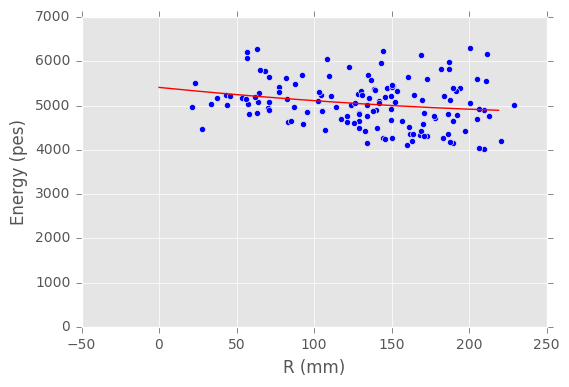

In [156]:
r = np.array([(xi**2 + yi**2)**0.5 for xi, yi in zip(x, y)])
plt.scatter(r, E)
plt.xlabel("R (mm)")
plt.ylabel("Energy (pes)")
plt.ylim((0,7000))
d = fit.fit_polynom(r, E, (6000., -1e-3, -1e-3))
xi = np.arange(0., 220.)
yi = fit.build_polynom(*d[0])(xi)
plt.plot(xi, yi, "r-")
print(d[0])

# SiPMs signal for some event

x, y, E = 200.0 200.0 0.0


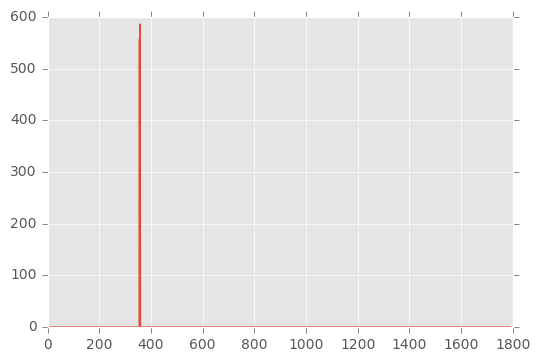

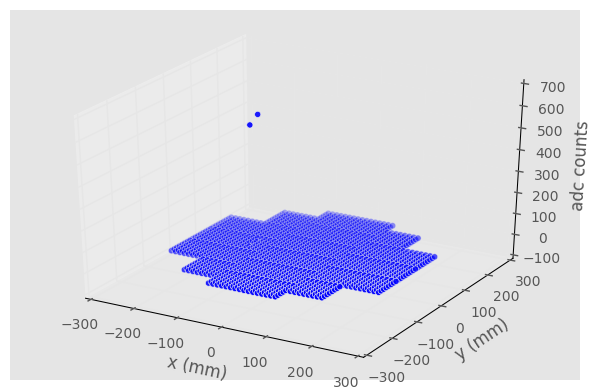

In [54]:
evt = 389
x, y, E = get_xye(pmtzswf[evt], sipmzswf[evt], sipmdf)
print("x, y, E =", x, y, E)
data = sipmzswf[evt].sum(axis=1)
data = wfm.suppress_wf(data, 0.8*np.max(data))
plt.plot(data)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sipmdf['x'], sipmdf['y'],data)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.set_zlabel("adc counts")
plt.tight_layout()